# Ground support script

Makes some useful figures to track convection etc

In [1]:
# Import a bunch of stuff


# Utilities
from datetime import datetime, timedelta
import intake
import os
import requests
from io import BytesIO

# Orcestra
from orcestra.flightplan import sal, bco, LatLon, IntoCircle, path_preview, plot_cwv, plot_path
from orcestra.utils import export_planet
# Satelite data
from goes2go.data import goes_nearesttime, goes_latest
from goes2go.tools import abi_crs
import goes


# The usual plotting business and array business
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np

# Image stuff
from PIL import Image



  

/Users/msin0007/opt/anaconda3/envs/ORCESTRA/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/Users/msin0007/opt/anaconda3/envs/ORCESTRA/lib/python3.12/site-packages/goes2go/data.py:665: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/Users/msin0007/opt/anaconda3/envs/ORCESTRA/lib/python3.12/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


## Set these parameters

In [2]:
# Set the time of this flight
take_off_time = datetime(2024, 8, 21, 12, 0, 0)

flight_id = 'HALO-' + take_off_time.strftime('%Y%m%d') +'a'

# Set the last forecast time for IFS
forecast_initialisation_time = datetime(2024, 8, 20, 12, 0, 0)

# Example of using timedelta
current_time = datetime.utcnow()
time_two_hours_ago = current_time - timedelta(hours=2)

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/1909725360.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


In [3]:
def make_output_dir(output_type):
   if not os.path.exists("./Figures/"+flight_id+"/"+output_type): 
       os.makedirs("./Figures/"+flight_id+"/"+output_type) 

make_output_dir('TCWV_forecast')
make_output_dir('VIS')
make_output_dir('IR')
make_output_dir('VIS_and_TPW')
make_output_dir('TPW')
make_output_dir('AOD')
make_output_dir('WV')



### First get the flight path

Can download this from here: https://orcestra-campaign.org/operation/halo.html

In [4]:
# Get the flight plan
# Download from: https://orcestra-campaign.org/operation/halo.html

radius = 130e3
atr_radius = 70e3

airport=sal

mindelo = LatLon(lat=16.8778, lon=-24.995)
north_in = LatLon(lat=15.00, lon=-26.71)


c_north = LatLon(13.7,-26.71)
c_south = LatLon(5.0, -26.71)
c_mid1=LatLon(11.1,-26.71)
c_mid2=LatLon(8.3,-26.71)

leg_south = [
    airport, 
    north_in.assign(fl=410),
]

leg_circles = [
    IntoCircle(c_south.assign(fl=430), radius, 360),
    IntoCircle(c_mid2.assign(fl=430), radius, 360),
    IntoCircle(c_mid1.assign(fl=430), radius, 360),
    IntoCircle(c_north.assign(fl=450), radius, 360),
]

leg_home = [
     north_in.assign(fl=450),
     airport
]  

path = leg_south+leg_circles+leg_home



### Now plot the forecast column water vapour

In [5]:
# Get the IFS forecast 
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

ds = cat.HIFS(datetime=forecast_initialisation_time.strftime('%Y-%m-%d %H:%M')).to_dask()


/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/706367869.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


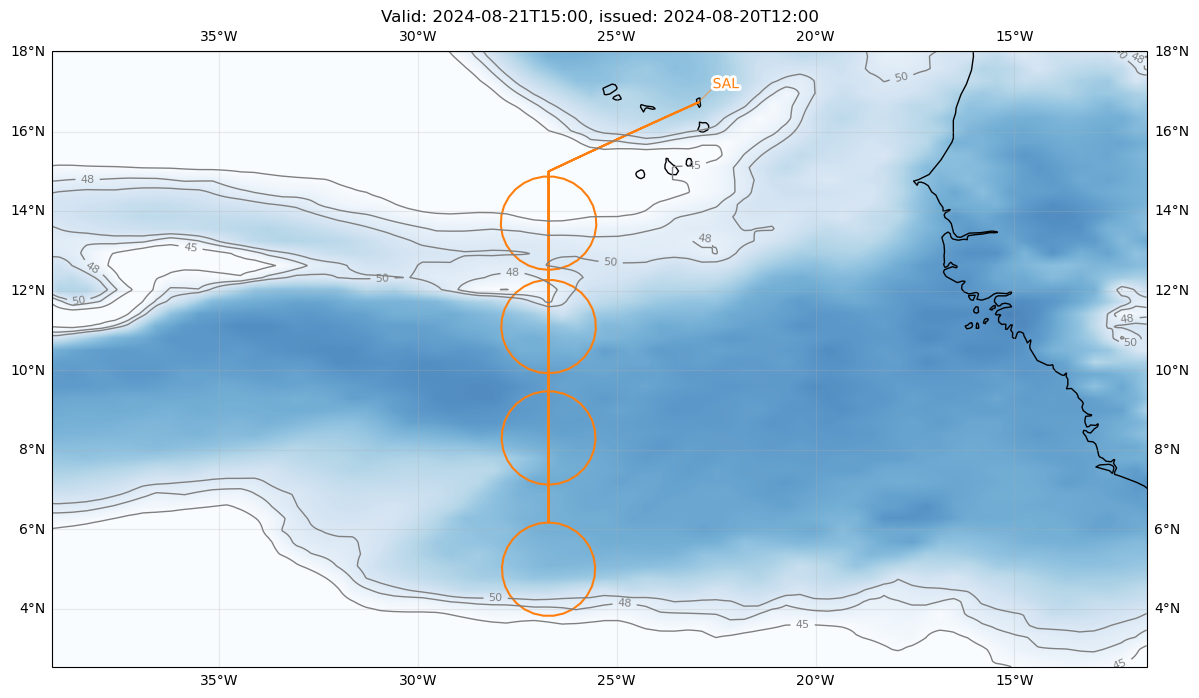

In [6]:
# PLot the column water vapour


# Select the one closest to current time
current_time = datetime.utcnow()
cwv_latest = ds["tcwv"].sel(time=current_time, method = "nearest")
time_of_cwv = ds["time"].sel(time=current_time, method = "nearest")

# Plot the flight path
ax = path_preview(path)

# PLot the column water vapour
plot_cwv(cwv_latest,levels=[45,48,50])

the_title = 'Valid: ' + str(time_of_cwv.values.astype('datetime64[m]')) + ', issued: ' + str(forecast_initialisation_time.strftime('%Y-%m-%dT%H:%M'))

plt.title(the_title)

export_planet('./Figures/'+flight_id+'/TCWV_forecast/TCWV_' + str(time_of_cwv.values.astype('datetime64[m]')) + '.png',dpi=100)


## Now plot GOES snapshots

### Visible

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/157134355.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


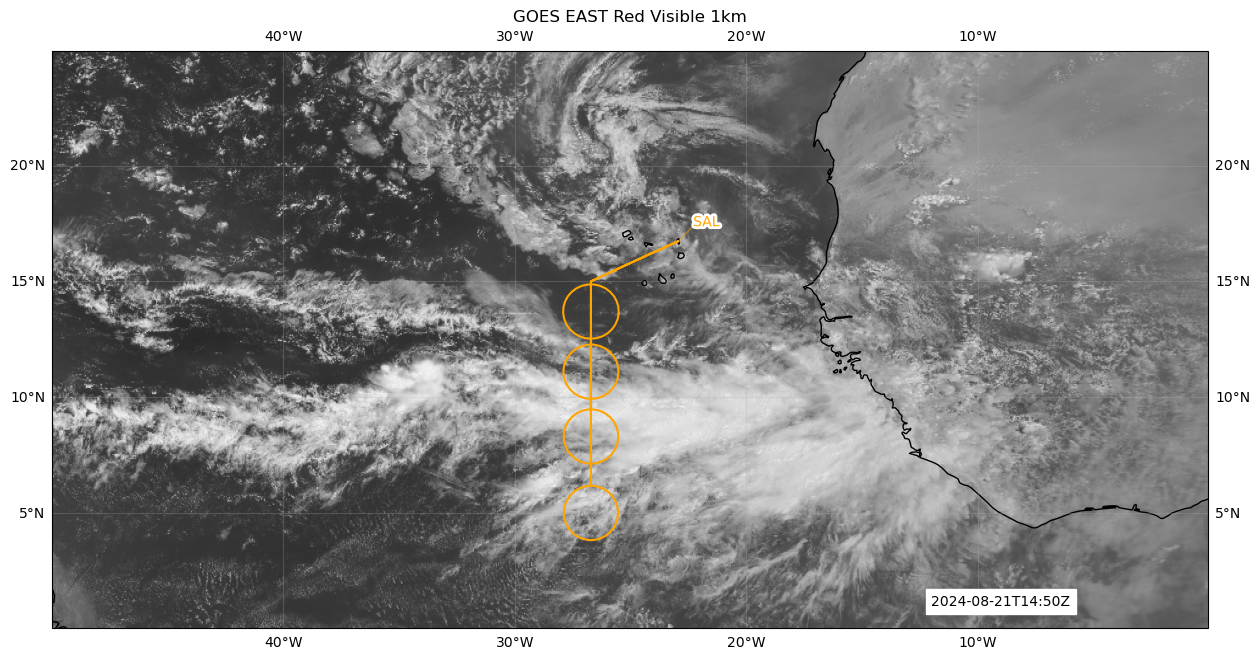

In [7]:
# Use NASA world view to get the most recent GOES visible image and plot it


# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate(sat_time, (-12, 1), backgroundcolor="white")

export_planet('./Figures/'+flight_id+'/VIS/GOES_vis_' + sat_time + '.png')




/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/121282695.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


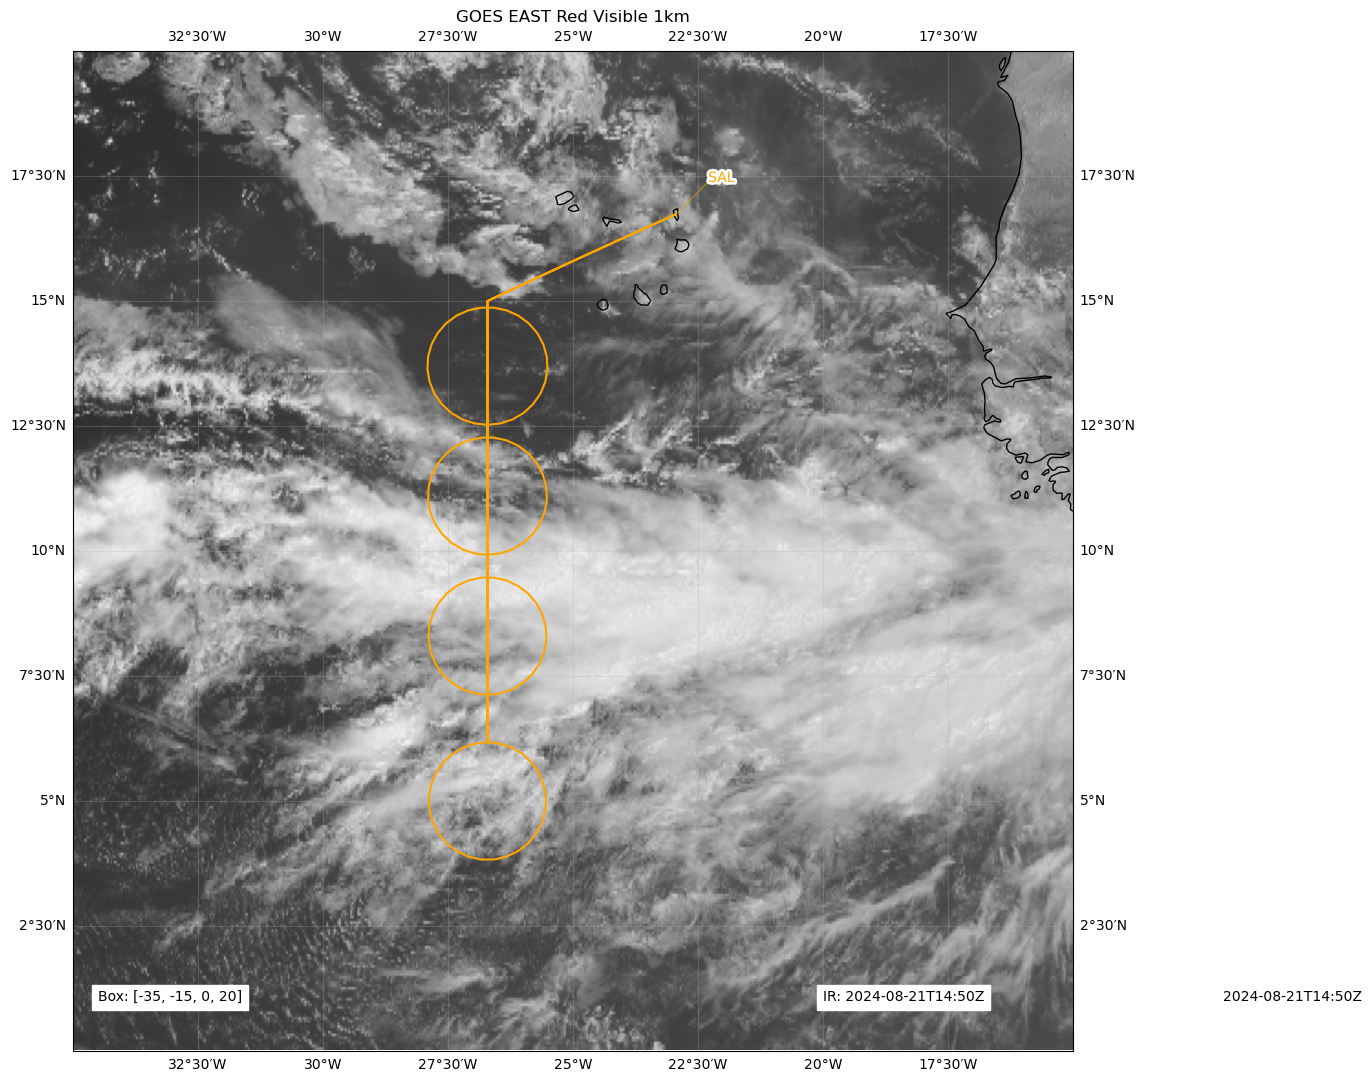

In [8]:

# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate(sat_time, (-12, 1), backgroundcolor="white")


box = [-35, -15, 0, 20]
ax.set_extent(box)



ax.set_position([0,0,1,1],which='both')

ax.annotate('IR: ' + sat_time, (-20, 1), backgroundcolor="white")

ax.annotate('Box: ' + str(box), (-34.5, 1), backgroundcolor="white")


fig.set_figwidth(10)
fig.set_figheight(10)
ax.set_aspect('auto')

export_planet('./Figures/Planet/VIS_GOES_' + sat_time + '.png')


### IR

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/1483997186.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


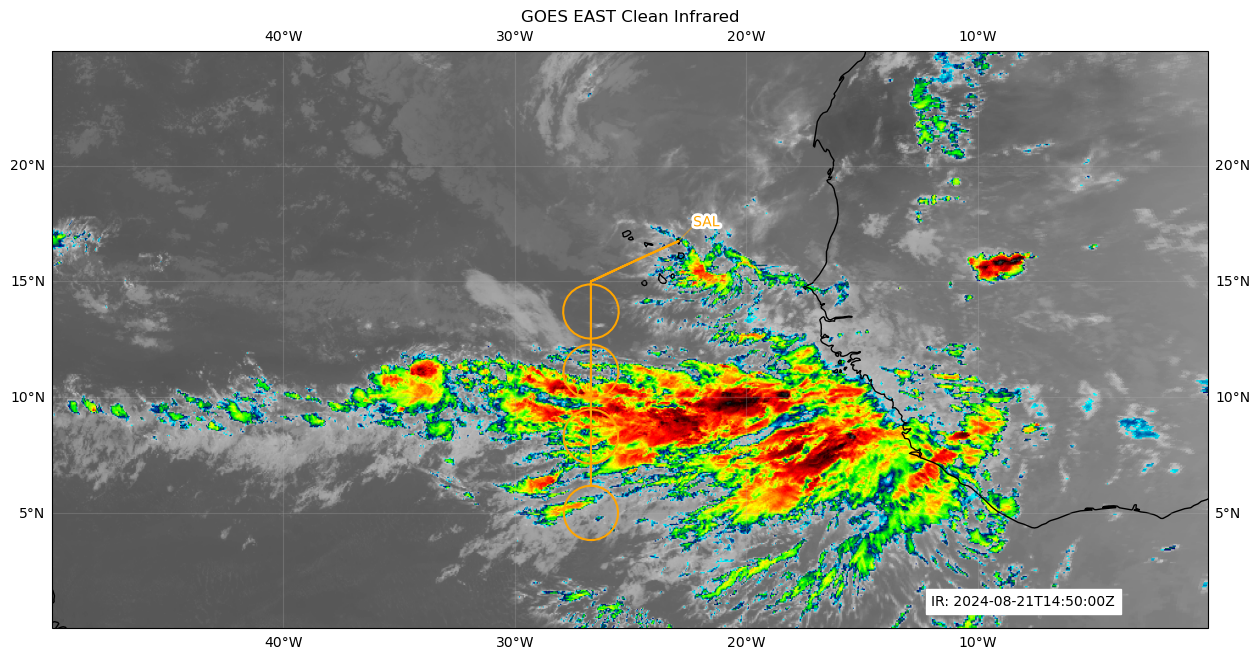

In [9]:
# Use NASA world view to get the most recent GOES visible image and plot it

# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_ir(current_time_pd)
ax = plt.gca()

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate('IR: ' + sat_time, (-12, 1), backgroundcolor="white")

export_planet('./Figures/'+flight_id+'/IR/GOES_IR_' + sat_time + '.png')


### Make an image that takes up the whole figure

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/4237359406.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


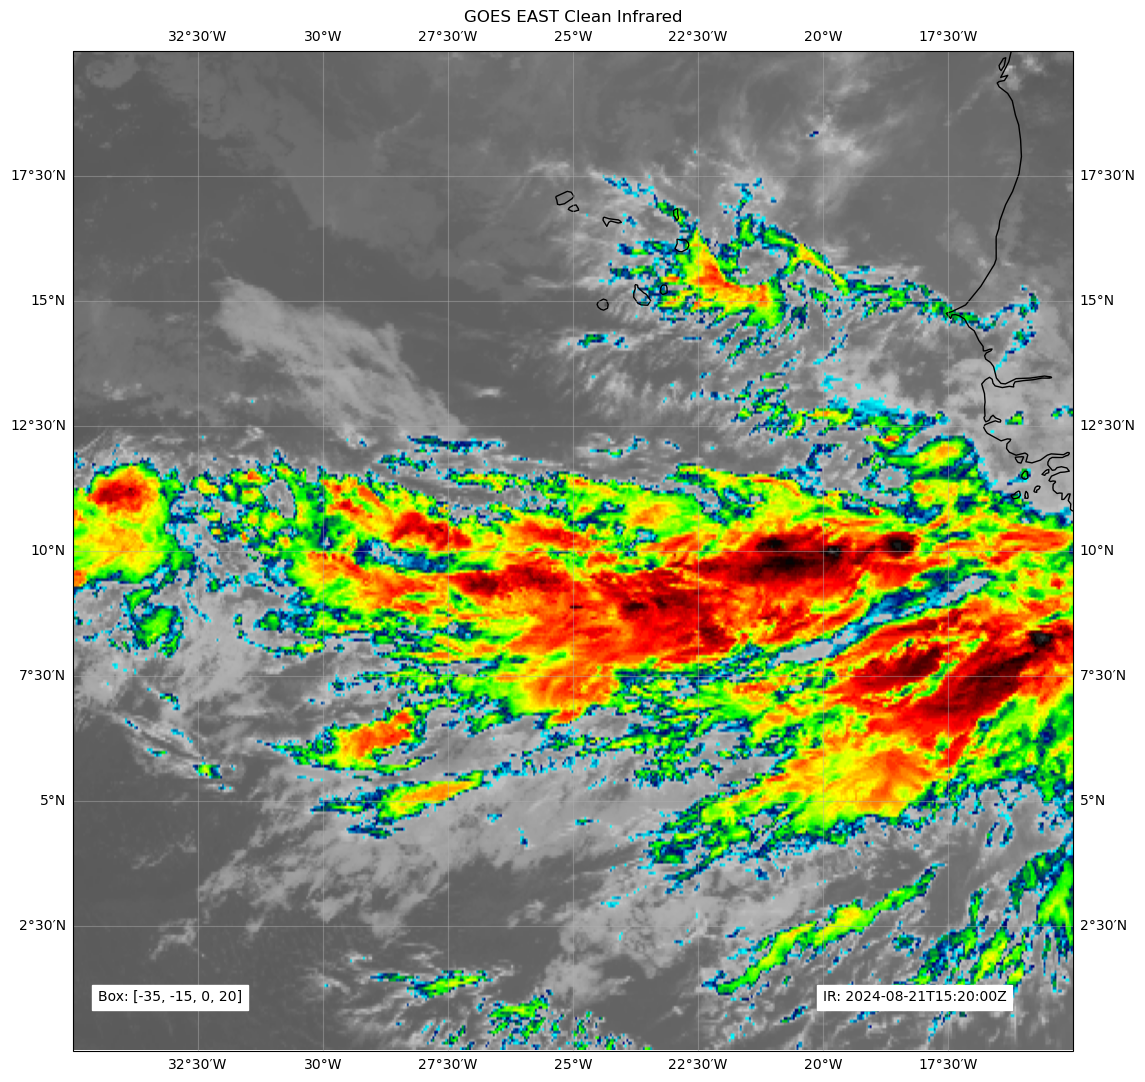

In [39]:
# Use NASA world view to get the most recent GOES visible image and plot it

# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_ir(current_time_pd)
ax = plt.gca()



ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, alpha = 0.25)




box = [-35, -15, 0, 20]
ax.set_extent(box)



ax.set_position([0,0,1,1],which='both')

ax.annotate('IR: ' + sat_time, (-20, 1), backgroundcolor="white")

ax.annotate('Box: ' + str(box), (-34.5, 1), backgroundcolor="white")


fig.set_figwidth(10)
fig.set_figheight(10)
ax.set_aspect('auto')

export_planet('./Figures/Planet/IR_GOES_' + sat_time + '.png')



## Total column water vapour products

### Download the TCWV from the ABI

In [11]:
current_time = datetime.utcnow()

try:
   
   print('downloading TPW data')
   # Get the latest TPW image
   g_TPW = goes_latest(satellite='goes16',product='ABI-L2-TPW', domain='F')

except:
   # Otherwise get something a bit older
   print("could not find latest TPW, trying to get file from 2 hours ago")
   time_sat = current_time - timedelta(hours=2)
   g_TPW = goes_nearesttime(time_sat, satellite=16, product="ABI-L2-TPW", domain = "F")


/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/878423445.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


downloading TPW data
📦 Finished downloading [1] files to [/Users/msin0007/data/noaa-goes16/ABI-L2-TPWF].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Visible and TPW

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/3434475014.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


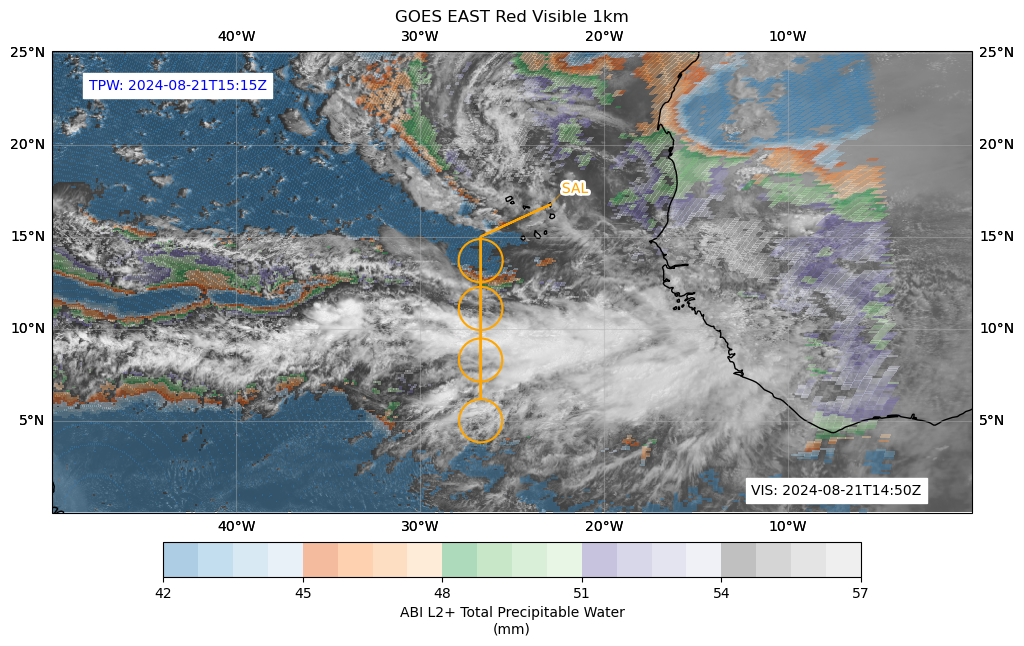

In [12]:
# Use NASA world view to get the most recent GOES visible image and plot it


# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate('VIS: ' + sat_time, (-12, 1), backgroundcolor="white")


# No idea what this does
crs, x, y = abi_crs(g_TPW, 'TPW')

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, g_TPW.TPW, transform=crs, cmap='tab20c', vmin=42,vmax=57,alpha=0.4)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{g_TPW.TPW.long_name}\n({g_TPW.TPW.units})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 23])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")

export_planet('./Figures/'+flight_id+'/VIS_and_TPW/GOES_vis_and_TPW_' + sat_time + '.png',dpi=200)



### ABI TPW on its own

<Figure size 1000x500 with 0 Axes>

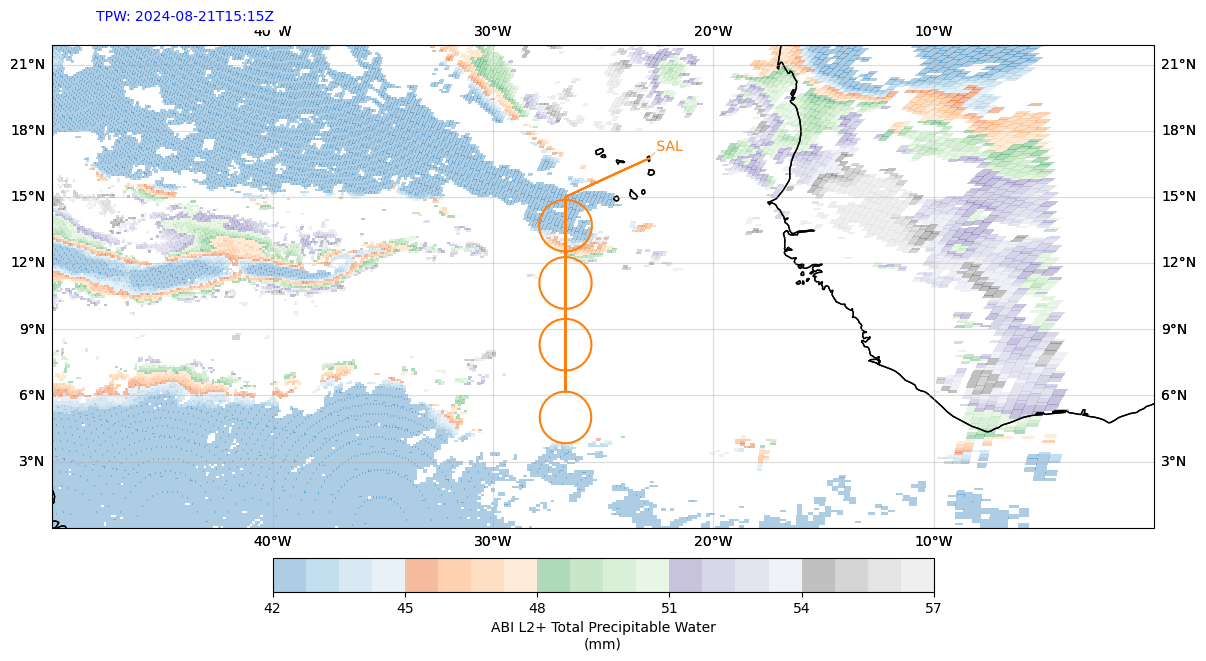

In [25]:
# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
ax = path_preview(path)
ax.set_global()
ax.coastlines()

# plot the water vapour field

# No idea what this does
crs, x, y = abi_crs(g_TPW, 'TPW')

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, g_TPW.TPW, transform=crs, cmap='tab20c', vmin=42,vmax=57,alpha=0.4)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{g_TPW.TPW.long_name}\n({g_TPW.TPW.units})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")


export_planet('./Figures/'+flight_id+'/TPW/GOES_TPW_' + str(g_TPW.t.values.astype('datetime64[m]')) + '.png',dpi=200)

### TCWV from daily AMRSU

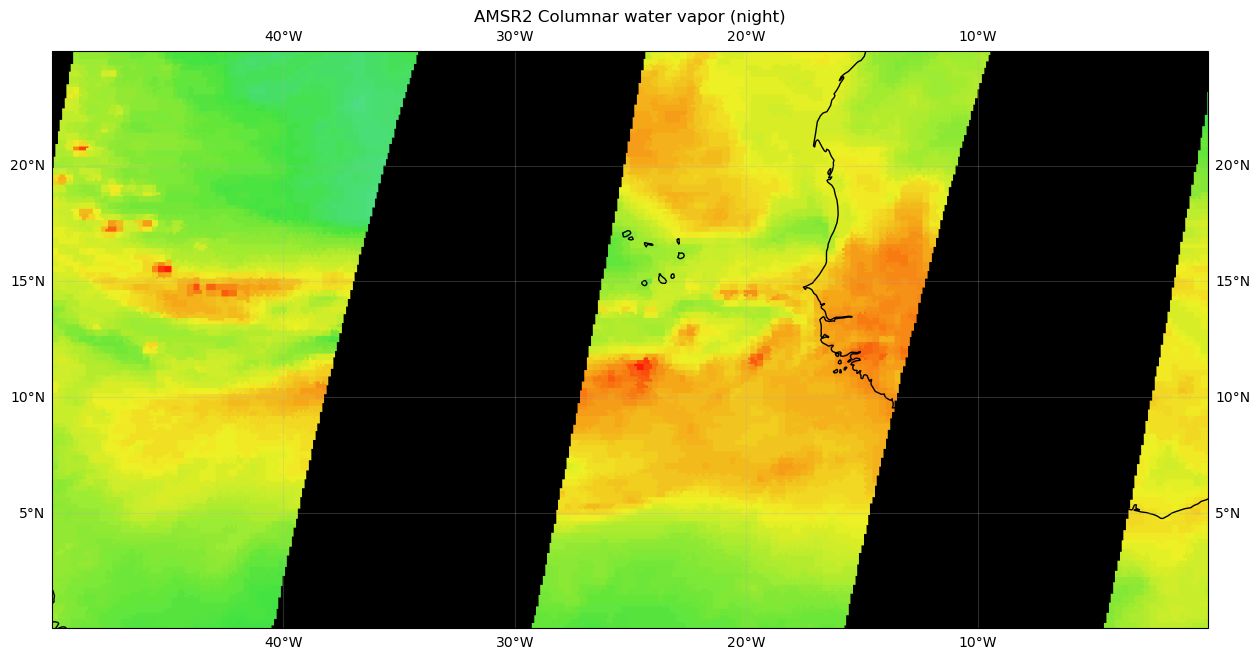

In [14]:
current_day = datetime.today()
current_day_pd = pd.Timestamp(current_day)


fig,sat_time,goes_image = goes.current_satellite_image_wv_night(current_day_pd)


/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_65429/3437649949.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


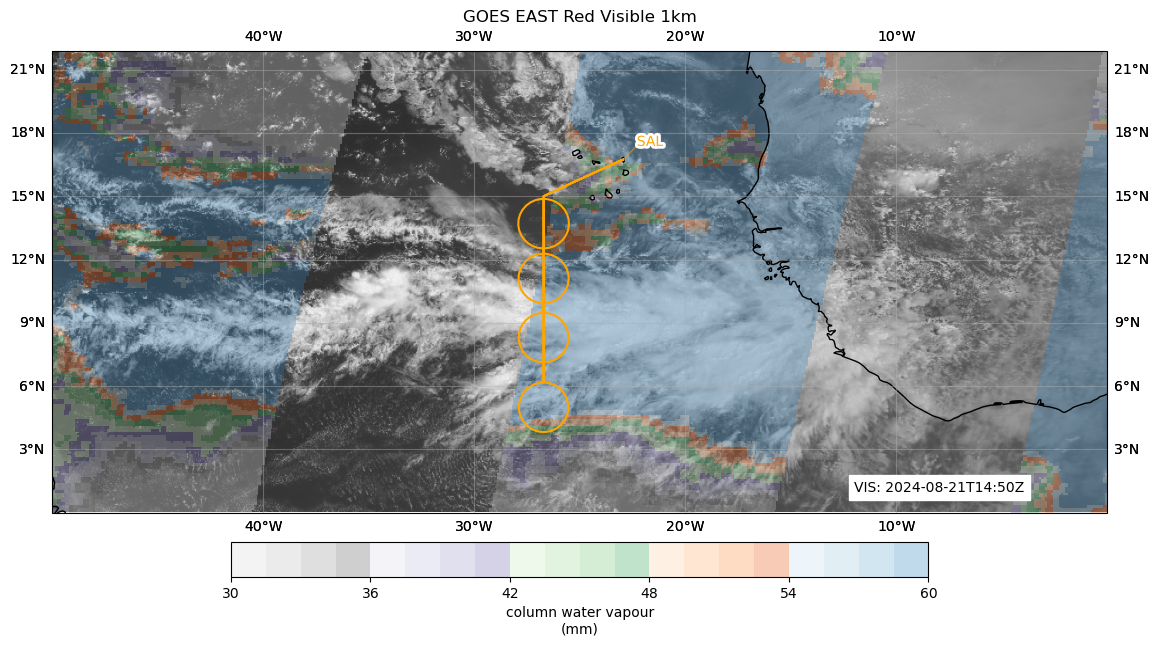

In [15]:
CWV = goes_image.values*(75/255)
CWV = CWV[0,:,:]
CWV = np.where(CWV==0,np.nan,CWV)


# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate('VIS: ' + sat_time, (-12, 1), backgroundcolor="white")


# plot the water vapour field



# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(goes_image.x, goes_image.y, CWV, cmap='tab20c_r', vmin=30,vmax=60,alpha=0.3)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"column water vapour\n(mm)",ticks=[30,36,42,48,54,60])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")

export_planet('./Figures/'+flight_id+'/VIS_and_TPW/GOES_VIS_AMSRU_TPW_' + sat_time + '.png',dpi=200)



### Column water vapour "MIMIC" from Microwave combined with Geostationary

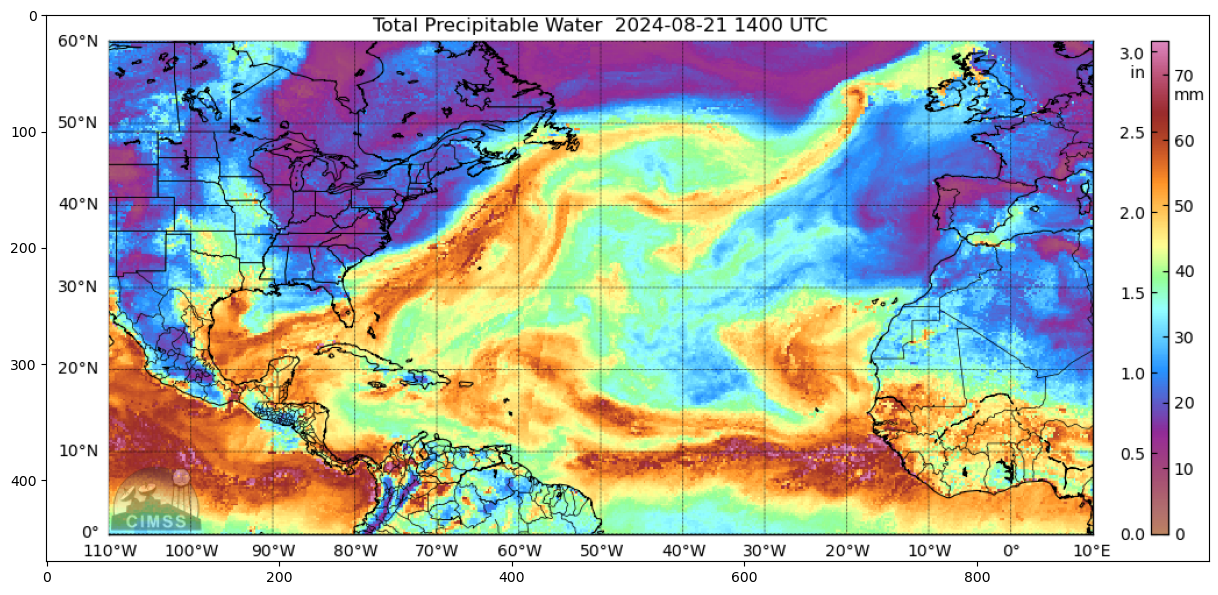

In [16]:
# Try to get the column water vapour image

url_prefix = 'https://tropic.ssec.wisc.edu/real-time/mtpw2/webImages/tpw_nrl_colors/natl/'
fname_url = url_prefix+"file_of_filenames_24.txt"


contents = requests.get(fname_url).text.splitlines()

# Going a few hours back on the recommendation of Florian
image_name = contents[-2]

sat_date = image_name[-23:-15]
sat_time = image_name[-14:-12]+':'+image_name[-10:-8]


image_name = url_prefix+image_name
response = requests.get(image_name)
TPW_image = np.array(Image.open(BytesIO(response.content)))


# This is super dumb. Sorry Lukas.

col = np.sum(TPW_image[:,:,0:3],2)

# Find the indices of the non-zero elements
indices = np.nonzero(col[120,:]<255*3)

# The first and last indices will be the first and last True values
Xf = indices[0][0]
Xl = indices[0][-1]

# Find the indices of the non-zero elements
indices = np.nonzero(col[:,200]<255*3)

# The first and last indices will be the first and last True values
Yf = indices[0][0]
Yl = indices[0][-1]


TPW_image_cropped = TPW_image[Yf:Yl,Xf:Xl,:]

colbar = TPW_image_cropped[:,-10,:]
colbar = colbar[-2:2:-1,:]/255

col = np.sum(TPW_image_cropped[:,:,0:3],2)

# Find the indices of the non-zero elements
indices = np.nonzero(col[120,:]==255*3)

# The first and last indices will be the first and last True values
Xf = indices[0][0]


TPW_image_cropped = TPW_image_cropped[:,:Xf,:]

N = np.shape(TPW_image_cropped);

x = np.linspace(-110,10,N[1])
y = np.linspace(0,60,N[0])

TPW_matrix = np.flipud(TPW_image_cropped)

TPW_values = TPW_matrix[:,:,0]/255*75


plt.figure(figsize=(15,9))
plt.imshow(TPW_image)


In [ ]:
x = np.linspace(-110,10,N[1])
y = np.linspace(0,60,N[0])

# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
ax = path_preview(path)
plot_path(path,ax=ax,color='blue')
ax.set_global()
ax.coastlines()

# plot the water vapour field

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, TPW_values, cmap='tab20c', vmin=42,vmax=57,alpha=1)

cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{'total column water'}\n({'mm'})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.annotate('TPW: ' + sat_date + ' ' + sat_time , (-12, 2), backgroundcolor="white")

export_planet('./Figures/'+flight_id+'/TPW/MIMIC_TPW2_tab' + sat_date + ' ' + sat_time + '.png',dpi=200)



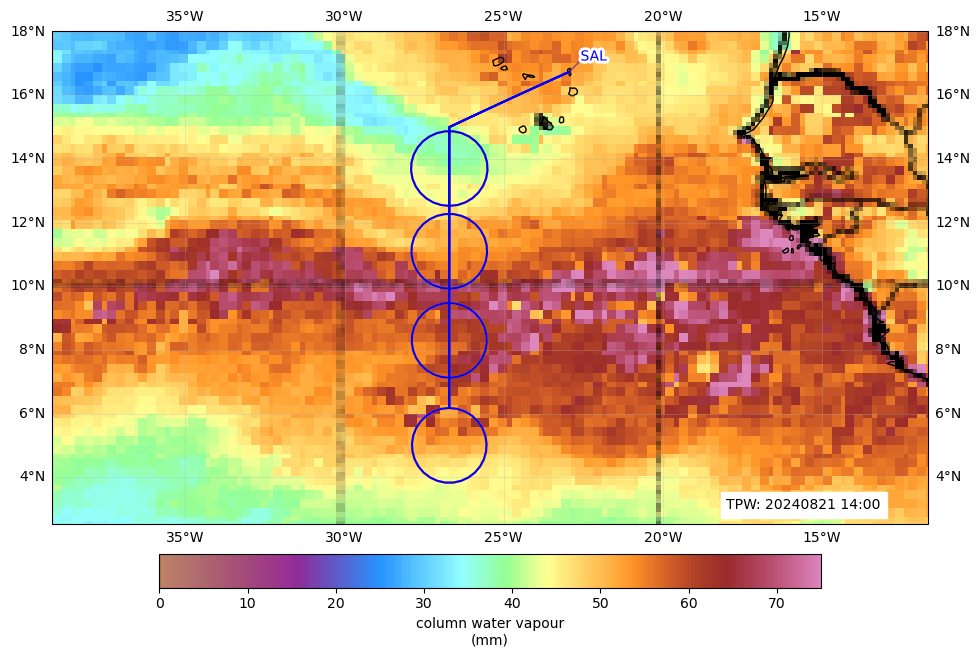

In [17]:

# For some reason I don't know how to create a geoaxes - so using path_preview to do this
ax = path_preview(path)
plot_path(path,ax=ax,color='blue')

newcmp = mpl.colors.ListedColormap(colbar)

c = ax.pcolormesh(x, y, TPW_matrix, cmap=newcmp, vmin=0,vmax=75,alpha=1)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"column water vapour\n(mm)",ticks=[0,10,20,30,40,50,60,70])

ax.annotate('TPW: ' + sat_date + ' ' + sat_time , (-18, 3), backgroundcolor="white")

plt.savefig('./Figures/'+flight_id+'/TPW/MIMIC_TPW2_' + sat_date + ' ' + sat_time + 'Z.png',dpi=200)




In [18]:
# Calculate the TPW values from the CWV image in an approximate way

# Values of the TPW that correspond to the colors in the colorbar
cwv_values = np.linspace(0,75,len(colbar)).tolist()

# Create some matrices that we can subtract
TPWm = TPW_matrix[:,:,0:3]/255
colm = colbar[:,0:3]

TPWm = np.tile(TPWm,[len(colm),1,1,1])
TPWm = np.transpose(TPWm,[0,3,1,2])

colm = np.tile(colm,[1,1,1,1])
colm = np.transpose(colm,[2,3,0,1])

# Distance between the TPW color and the values in the colorbar
dist = np.sum((TPWm-colm)**2,1)

# Find the index of the colorbar closest to each color
I = dist.argmin(axis=0)

# Now go through the image matrix and calculate the actual cwv value
# This should not use a loop (sorry Lukas)
N = np.shape(I)
TWP_values = np.zeros(np.shape(I))
for i in range(N[0]-1):
   for j in range(N[1]-1):

      TPW_values[i,j] = cwv_values[I[i,j]]
    


<Figure size 1000x500 with 0 Axes>

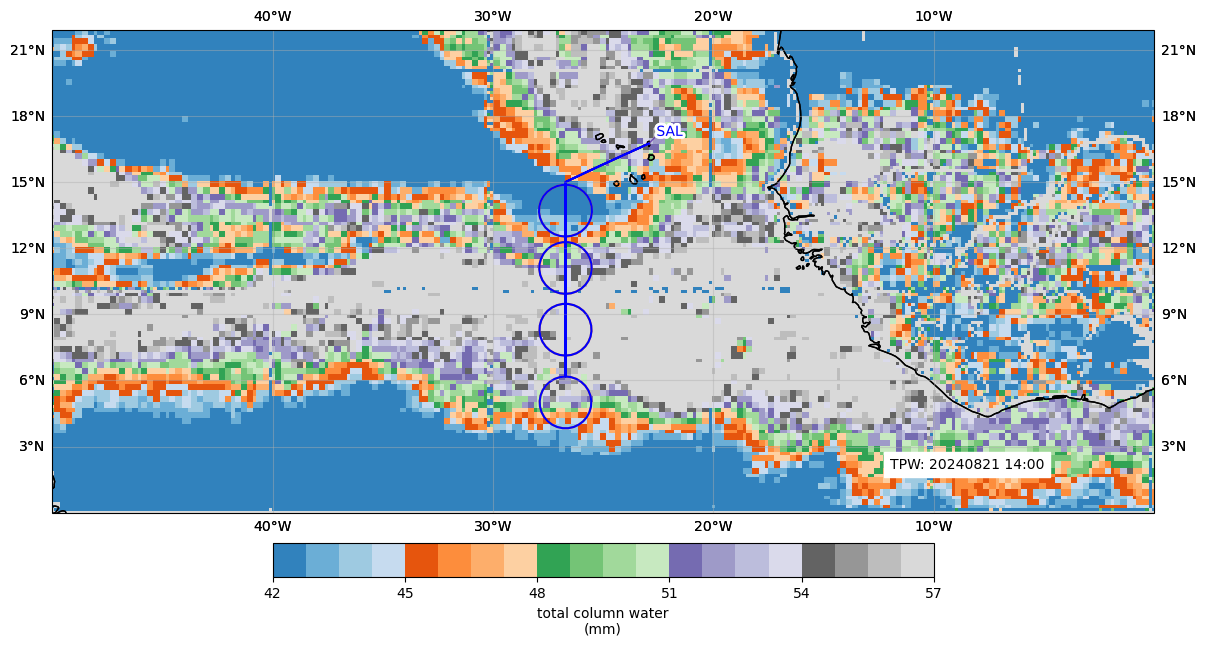

In [24]:
x = np.linspace(-110,10,N[1])
y = np.linspace(0,60,N[0])

# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
ax = path_preview(path)
plot_path(path,ax=ax,color='blue')
ax.set_global()
ax.coastlines()

# plot the water vapour field

# Plot the Total column water vapor
c = ax.pcolormesh(x, y, TPW_values, cmap='tab20c', vmin=42,vmax=57,alpha=1)

cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{'total column water'}\n({'mm'})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.annotate('TPW: ' + sat_date + ' ' + sat_time , (-12, 2), backgroundcolor="white")

export_planet('./Figures/'+flight_id+'/TPW/MIMIC_TPW2_tab' + sat_date + ' ' + sat_time + 'Z.png',dpi=200)



### Download AOD data

In [20]:
try:
   print('downloading AOD data')
   # Get the latest AOD image
   g_AOD = goes_latest(satellite='goes16',product='ABI-L2-AOD', domain='F')

except:
   # Otherwise get something a bit older
   print("could not find latest AOD, trying to get file from 2 hours ago")
   time_sat = current_time - timedelta(hours=2)
   g_AOD = goes_nearesttime(time_sat, satellite=16, product="ABI-L2-AOD", domain = "F")



downloading AOD data
📦 Finished downloading [1] files to [/Users/msin0007/data/noaa-goes16/ABI-L2-AODF].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Aerosol optical depth

<Figure size 1000x500 with 0 Axes>

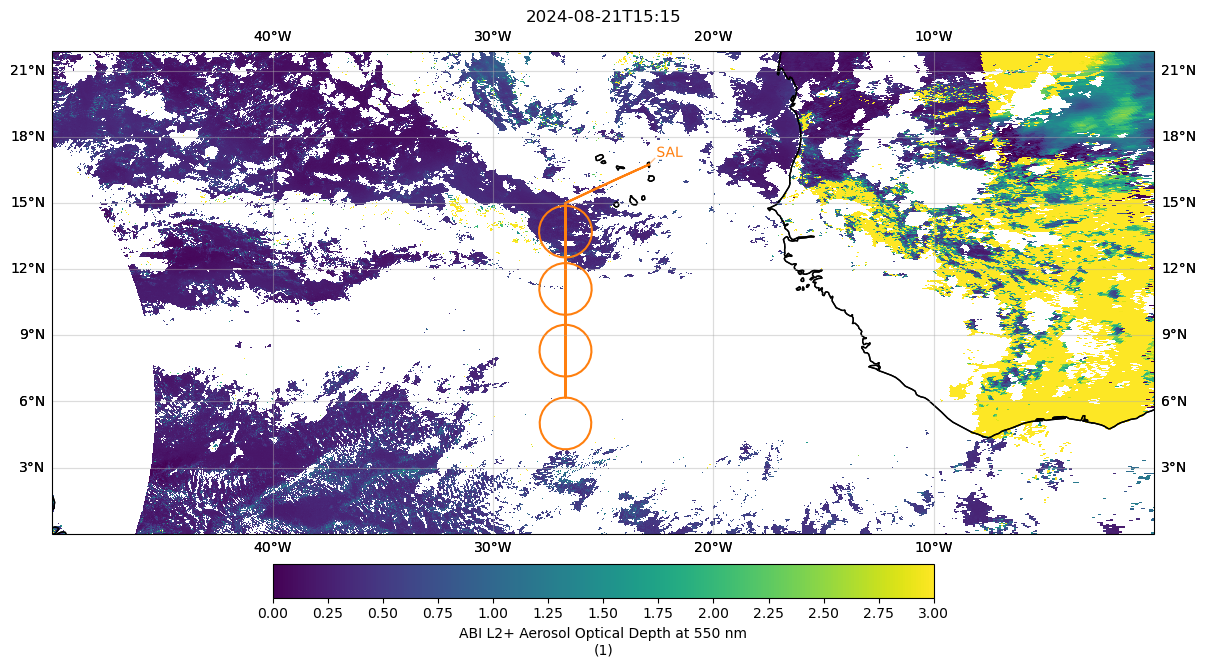

In [21]:
# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
ax = path_preview(path)
ax.set_global()
ax.coastlines()


# No idea what this does
crs, x, y = abi_crs(g_AOD, 'AOD')

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, g_AOD.AOD, transform=crs, cmap='viridis', vmin=0,vmax=3,alpha=1)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{g_AOD.AOD.long_name}\n({g_AOD.AOD.units})",ticks=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

plt.title(g_AOD.t.values.astype('datetime64[m]'))

export_planet('./Figures/'+flight_id+'/AOD/GOES_AOD_' + str(g_AOD.t.values.astype('datetime64[m]')) + '.png',dpi=200)


### Download the full ABI data
This takes a long time, so commented out for now
But it can give you snapshots of the "water vapur" estimate from a mixture of channels

In [22]:
# # Download the latest GOES information. This might take a long time
# try:
#    print('downloading ABI data')
#    # Get the latest visible image
#    g_visible = goes_latest(satellite='goes16',product='ABI',domain = 'F')

# except:
#    # Otherwise get something a bit older
#    print("could not find latest VIS, trying to get file from 2 hours ago")
#    time_sat = current_time - timedelta(hours=2)
#    g_visible = goes_nearesttime(time_sat, satellite=16, product="ABI", domain = "F")

# rgb_products = [i for i in dir(g_visible.rgb) if i[0].isupper()]
# rgb_products


In [23]:

# # Plot the flight path
# ax = path_preview(path)
# ax.set_global()
# ax.coastlines()


# # No idea what this does
# goes_kwargs = g_visible.rgb.imshow_kwargs

# RGB = getattr(g_visible.rgb, 'WaterVapor')()

# # Plot the GOES visible satelite image
# ax.imshow(RGB, transform = g_visible.rgb.crs, regrid_shape=3500, interpolation='nearest') 

# ax.set_extent([-50, 0, 0, 20])
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


# ax.set_title(f"{g_visible.orbital_slot} {'WaterVapor'}", loc='left', fontweight='bold')
# ax.set_title(f"{g_visible.t.dt.strftime('%H:%M UTC %d-%b-%Y').item()}", loc="right")



# plt.savefig('../Figures/'+flight_id+'/WV/GOES_WV_' + str(g_visible.t.values.astype('datetime64[m]')) + '.png',dpi=200)



In [27]:
contents = requests.get('https://api.aviationstack.com/v1/flights?access_key=d3b255e8b9a50e8a0d3de72ee70fe7de')


In [66]:
params = {
  'access_key': 'd3b255e8b9a50e8a0d3de72ee70fe7de',
  'flight_status': 'active'
}

api_result = requests.get('https://api.aviationstack.com/v1/flights', params)

api_response = api_result.json()


TypeError: 'NoneType' object is not subscriptable

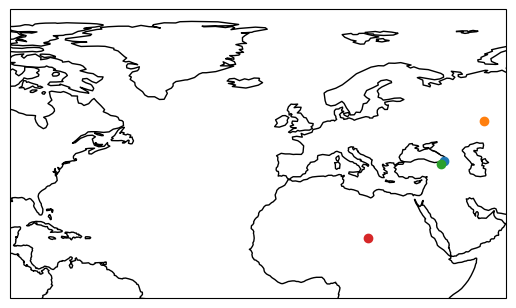

In [78]:

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

box = [-90, 60, 0, 80]
ax.set_extent(box)


for flight in api_response['data']:
    if (flight['live'] is not None):

        lat = flight['live']['latitude']
        lon = flight['live']['latitude']
        plt.plot(lon,lat,'o')

        #print(u'%s flight %s from %s (%s) to %s (%s) is in the air.' % (
        #    flight['airline']['name'],
        #    flight['flight']['iata'],
        #    flight['departure']['airport'],
        #    flight['departure']['iata'],
        #    flight['arrival']['airport'],
        #    flight['arrival']['iata']))


plt.show()